# TODO:

- store output of state vars in xarray-simlab data structure
    1. for gekko solver
    2. for odeint solver
    3. for step-wise solver
    
this needs to be completely wrapped in the backend..
i need to somehow combine the "core.parts" so that they are automatically initialized with the xs.Model

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xsimlab as xs

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.main import ModelCore, Solver

from phydra.processes.statevars import SV, Time

from phydra.processes.fluxes import Flux

In [5]:
Model = phydra.create({'core':ModelCore, 'solver':Solver, 'time':Time, 
                       'y':SV, 'loss':Flux,
                      #'x':SV, 'x_loss':Flux
                      })

In [6]:
Model

<xsimlab.Model (5 processes, 4 inputs)>
core
    solver_type     [in]
time
    days            [in] ('days',) time in days
y
    init            [in]
loss
    k               [in]
solver

In [7]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.01),
            input_vars={
                'y__init':0.5,
                'loss__k':0.5
            },
            output_vars={
                'y__value':None,
            })

In [8]:
gekko_setup = phydra.setup('gekko', Model,
            time=np.arange(0,20,0.01),
            input_vars={
                'y__init':0.5,
                'loss__k':0.5
            },
            output_vars={
                'y__value':None,
                'time__value':None
            })

In [9]:
stepwise_setup = phydra.setup('stepwise', Model,       
            time=np.arange(0,20,0.1),
            input_vars={
                'y__init':0.5,
                'loss__k':0.5
            },
            output_vars={
                'y__value':None
            })

In [10]:
stepwise_setup


<xarray.Dataset>
Dimensions:            (days: 1, time: 200)
Coordinates:
  * time               (time) float64 0.0 0.1 0.2 0.3 ... 19.6 19.7 19.8 19.9
Dimensions without coordinates: days
Data variables:
    y__init            float64 0.5
    loss__k            float64 0.5
    core__solver_type  <U8 'stepwise'
    time__days         (days) int64 0
Attributes:
    __xsimlab_output_vars__:  y__value

In [11]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=Model)
    
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=Model)

with ProgressBar(frontend="console"):
        out_ds2 = stepwise_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 
███▎        33% | initialize 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable loss
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00094 seconds
here unpacking values time
here unpacking values y
finalizing: cleanup
initializing model core
Initializing Model Time
initializing state variable y
initializing state variable loss
assembling model
SOLVER : gekko


██████████ 100% | Simulation finished in 00:05 
██████▌     66% | run step 131/199 

Model was solved in 5.58 seconds
finalizing: cleanup
initializing model core
Initializing Model Time
initializing state variable y
initializing state variable loss
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 


finalizing: cleanup


In [12]:
out_ds

<xarray.Dataset>
Dimensions:            (clock: 2, days: 2000, time: 2000)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: days, time
Data variables:
    core__solver_type  <U6 'odeint'
    loss__k            float64 0.5
    time__days         (days) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.4975 0.495 ... 2.293e-05 2.281e-05

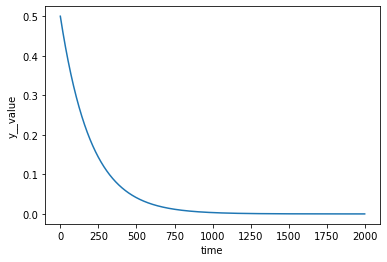

In [13]:
out_ds.y__value.plot()

In [14]:
out_ds1

<xarray.Dataset>
Dimensions:            (clock: 2, days: 2000, time: 2000)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: days, time
Data variables:
    core__solver_type  <U5 'gekko'
    loss__k            float64 0.5
    time__days         (days) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
    time__value        (time) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.4975 0.495 ... 2.293e-05 2.281e-05

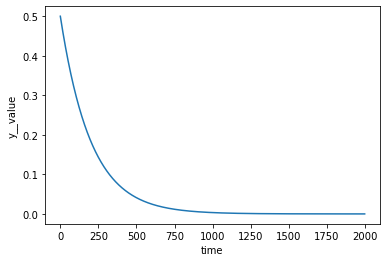

In [15]:
out_ds1.y__value.plot()

In [16]:
out_ds2

<xarray.Dataset>
Dimensions:            (days: 1, time: 200)
Coordinates:
  * time               (time) float64 0.0 0.1 0.2 0.3 ... 19.6 19.7 19.8 19.9
Dimensions without coordinates: days
Data variables:
    core__solver_type  <U8 'stepwise'
    loss__k            float64 0.5
    time__days         (days) int64 0
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.475 0.4512 ... 1.942e-05 1.845e-05

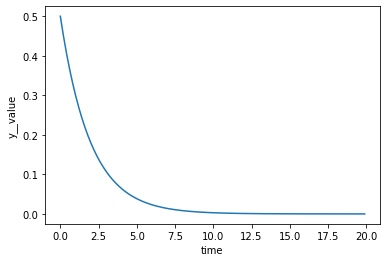

In [17]:
out_ds2.y__value.plot()